In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import datetime
import os
import seaborn as sns
from datetime import date
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import LabelBinarizer

In [2]:
xtrain = pd.read_csv("Airbnb_xtrain_v3.csv",index_col=0)
ytrain = pd.read_csv("Airbnb_ytrain_v3.csv",index_col=0)

In [4]:
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,634,635,636,637,638,639,640,641,642,643
0,-1.636936,-1.726377,-0.426043,-0.429566,2.285233,-0.424266,-0.406666,-0.360915,-0.369587,1.644862,...,0.258163,0.531805,0.205168,-0.286186,0.078774,0.445554,2.587670,2.096751,0.561215,-0.326086
1,-1.636936,-1.726377,-0.426043,-0.429566,2.285233,-0.424266,-0.406666,-0.360915,-0.369587,1.644862,...,-0.469575,-0.564947,-0.504728,-0.438692,-0.496693,-0.592403,-0.450084,-0.630340,-0.529318,-0.326086
2,-1.636936,-1.726377,-0.426043,-0.429566,2.285233,-0.424266,-0.406666,-0.360915,-0.369587,1.644862,...,-0.469575,-0.483706,-0.504728,-0.514944,-0.661112,-0.592403,0.718283,0.460497,-0.529318,-0.326086
3,-1.636936,-1.726377,-0.426043,-0.429566,2.285233,-0.424266,-0.406666,-0.360915,-0.369587,1.644862,...,0.588953,0.328703,0.864357,1.620127,-0.085645,-0.015760,0.951956,3.187587,0.561215,-0.326086
4,-1.636936,-1.726377,-0.426043,-0.429566,2.285233,-0.424266,-0.406666,-0.360915,-0.369587,1.644862,...,-0.204943,-0.483706,-0.555435,-0.591197,-0.661112,-0.707731,-0.683758,-0.630340,-0.529318,-0.326086


In [5]:
ytrain.head()

,0
0,11
1,7
2,7
3,7
4,5


In [6]:
xtrain_new = xtrain.values
ytrain_new = ytrain.values

## Estimate model

In [7]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):

    """
    y_true : array, shape = [n_samples] 
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] # Sort the score from high to low
    y_true = np.take(y_true, order[:k]) # Get top k score

    gain = 2 ** y_true - 1   

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):   

    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 
    k : int
        Rank.
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)    
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


## Logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

RANDOM_STATE = 2018 

# set the iterations
iteration = [1, 5, 10, 15, 20, 30, 50]
kf = KFold(n_splits=5, random_state=RANDOM_STATE)

train_score = []
cv_score = []

# select a k:
k_ndcg = 5

for i, item in enumerate(iteration): 

    lr = LogisticRegression(max_iter=item, tol=1e-5, solver='newton-cg', multi_class='ovr') 
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

        lr.fit(X_train, y_train)

        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)


        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)

    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))


/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optim

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optim

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was 

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converg

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converg

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converg

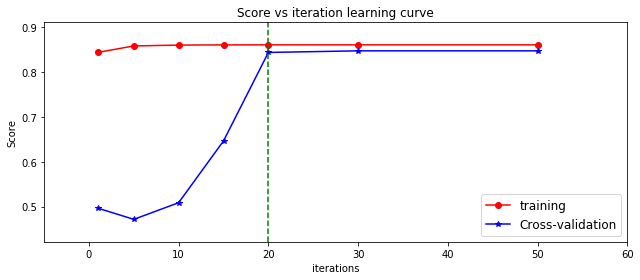

In [9]:

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05
cv_score_lr = np.max(cv_score)

plt.figure(figsize=(9,4))
plt.plot(iteration, train_score, 'ro-', label = 'training')
plt.plot(iteration, cv_score, 'b*-', label = 'Cross-validation')
plt.xlabel("iterations")
plt.ylabel("Score")
plt.xlim(-5, np.max(iteration)+10)
plt.ylim(ymin, ymax)
plt.plot(np.linspace(20,20,50), np.linspace(ymin, ymax, 50), 'g--')
plt.legend(loc = 'lower right', fontsize = 12)
plt.title("Score vs iteration learning curve")

plt.tight_layout()
plt.savefig('LR-iter.png')


## Tree

In [10]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.svm import SVC, LinearSVC, NuSVC
LEARNING_RATE = 0.1
N_ESTIMATORS = 80
RANDOM_STATE = 2018
MAX_DEPTH = 7

# Build a dictionary
clf_tree ={
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                    random_state=RANDOM_STATE),

    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                 max_depth=MAX_DEPTH,
                                 random_state=RANDOM_STATE),

    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                   learning_rate=LEARNING_RATE,
                                   random_state=RANDOM_STATE),

    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS,
                                 random_state=RANDOM_STATE),

    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH,
                                      n_estimators=N_ESTIMATORS,
                                      random_state=RANDOM_STATE),

    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH,
                                           n_estimators=N_ESTIMATORS,
                                           random_state=RANDOM_STATE)
}
train_score = []
cv_score = []
tree_name = []

kf = KFold(n_splits=5, random_state=RANDOM_STATE)

k_ndcg = 5


for key in clf_tree.keys():

    clf = clf_tree.get(key)

    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)

    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))
    tree_name.append(key)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DataConversionWarning: A column-vector y was passed whe

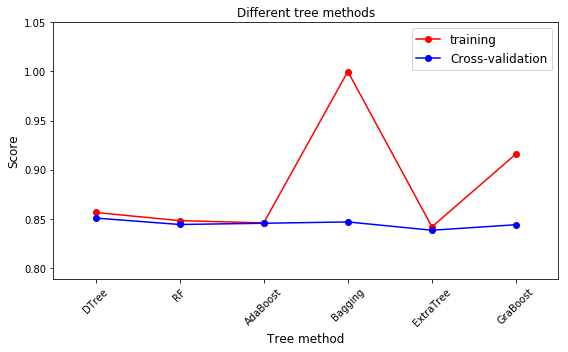

In [11]:
train_score_tree = train_score
cv_score_tree = cv_score

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = tree_name

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_tree, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()
plt.savefig('tree.png')

## SVM

In [12]:
TOL = 1e-4
MAX_ITER = 1000
svm_name = []

clf_svm = {

    'SVM-rbf': SVC(kernel='rbf',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     

    'SVM-poly': SVC(kernel='poly',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     

    'SVM-linear': SVC(kernel='linear',
                      max_iter=MAX_ITER,
                      tol=TOL, 
                      random_state=RANDOM_STATE,
                      decision_function_shape='ovr'),  

    'LinearSVC': LinearSVC(max_iter=MAX_ITER,
                            tol=TOL,
                            random_state=RANDOM_STATE,
                            multi_class = 'ovr') 
    }

train_score_svm = []
cv_score_svm = []

kf = KFold(n_splits=5, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_svm.keys():

    clf = clf_svm.get(key)

    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.decision_function(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.decision_function(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)

    train_score_svm.append(np.mean(train_score_iter))
    cv_score_svm.append(np.mean(cv_score_iter))
    svm_name.append(key)

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array 

/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/xiaolongxia/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

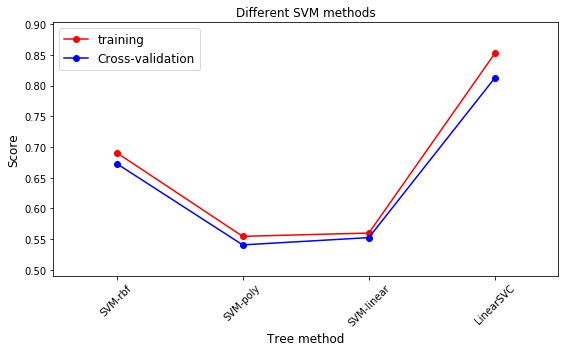

In [13]:
ymin = np.min(cv_score_svm)-0.05
ymax = np.max(train_score_svm)+0.05

x_ticks = svm_name

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_svm, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_svm, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 3.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different SVM methods")

plt.tight_layout()
plt.savefig('svm.png')

## Xgboost

In [14]:
import xgboost as xgb

def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score

params = {}
params['colsample_bytree'] = 0.6
params['max_depth'] = 6
params['subsample'] = 0.8
params['eta'] = 0.1
params['seed'] = RANDOM_STATE
params['num_class'] = 12
params['objective'] = 'multi:softprob' 
params['eval_metric'] = 'merror'
train_score_iter = []
cv_score_iter = []
NUM_XGB = 30
kf = KFold(n_splits = 5, random_state=RANDOM_STATE)
k_ndcg = 5
key = 'XGboost'
for train_index, test_index in kf.split(xtrain_new, ytrain_new):

    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

    train_xgb = xgb.DMatrix(X_train, label= y_train)
    test_xgb = xgb.DMatrix(X_test, label = y_test)

    watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]

    bst = xgb.train(params, 
                     train_xgb,
                     NUM_XGB,
                     watchlist,
                     feval = customized_eval,
                     verbose_eval = 5)


    y_pred = np.array(bst.predict(test_xgb))
    y_pred_train = np.array(bst.predict(train_xgb))
    train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)

train_score_xgb = np.mean(train_score_iter)
cv_score_xgb = np.mean(cv_score_iter)
print ("\nThe training score is: {}".format(train_score_xgb))
print ("The cv score is: {}\n".format(cv_score_xgb))


[04:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[04:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[04:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[04:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[04:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[04:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[04:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[04:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[04:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes,

[5]	train-merror:0.284478	test-merror:0.294723	train-ndcg5:0.866481	test-ndcg5:0.85782
[04:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[04:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[04:09:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[04:09:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[04:09:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[04:09:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[04:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[04:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[04:09:28] sr

[04:10:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[04:10:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[04:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[04:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[04:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[04:10:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[04:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[04:11:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[04:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes,

[04:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[04:12:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[04:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[04:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[04:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[04:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[04:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[04:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[04:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes

[04:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[04:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[04:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[04:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[04:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[04:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[04:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[04:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[04:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes

[29]	train-merror:0.265224	test-merror:0.290591	train-ndcg5:0.880674	test-ndcg5:0.859765
[04:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[04:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[04:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[04:16:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[04:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[04:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[04:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[04:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[04:16:33] 

[5]	train-merror:0.282751	test-merror:0.302716	train-ndcg5:0.867911	test-ndcg5:0.852325
[04:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[04:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[04:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[04:18:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[04:18:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[04:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[04:18:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[04:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=8
[04:18:06] s

[04:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[04:19:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[04:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[04:19:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[04:19:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[04:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[04:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[04:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[04:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes,

[04:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[04:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[04:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[04:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[04:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[04:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[04:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[04:21:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[04:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes

[04:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[04:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=8
[04:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[04:22:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[04:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[04:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[04:22:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[04:22:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[04:22:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes

[29]	train-merror:0.263412	test-merror:0.299804	train-ndcg5:0.881756	test-ndcg5:0.85344
[04:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[04:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[04:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[04:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[04:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[04:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[04:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[04:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[04:25:12] 

[5]	train-merror:0.282141	test-merror:0.305223	train-ndcg5:0.868208	test-ndcg5:0.849102
[04:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[04:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[04:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[04:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[04:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[04:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[04:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[04:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[04:26:44]

[04:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[04:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[04:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[04:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[04:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[04:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[04:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[04:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[04:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes,

[04:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[04:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[04:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[04:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[04:29:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[04:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[04:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[04:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[04:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes

[04:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[04:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[04:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[04:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[04:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[04:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[04:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[04:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[04:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[29]	train-merror:0.263784	test-merror:0.301497	train-ndcg5:0.881772	test-ndcg5:0.851095
[04:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[04:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[04:33:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[04:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[04:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[04:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[04:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[04:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[04:33:49] 

[5]	train-merror:0.283208	test-merror:0.301971	train-ndcg5:0.867713	test-ndcg5:0.849256
[04:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[04:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[04:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[04:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[04:35:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[04:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[04:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[04:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=8
[04:35:21] s

[04:36:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[04:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[04:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[04:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[04:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[04:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[04:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[04:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[04:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes,

[04:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[04:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[04:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[04:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[04:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[04:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[04:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=8
[04:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[04:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes

[04:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[04:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[04:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[04:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[04:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[04:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=8
[04:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[04:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[04:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes,

[04:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[04:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[04:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[04:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[04:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[04:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[04:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[04:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[04:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes,

[04:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[04:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[04:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[04:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[04:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[04:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[04:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[04:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[04:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes

[04:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[04:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[04:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[04:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[04:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[04:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[04:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[04:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[04:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes

[04:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[04:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[04:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[04:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[04:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[04:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[04:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=8
[04:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[04:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes

[04:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[04:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[04:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[04:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[04:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[04:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[04:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=8
[04:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[04:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes,

## Compare

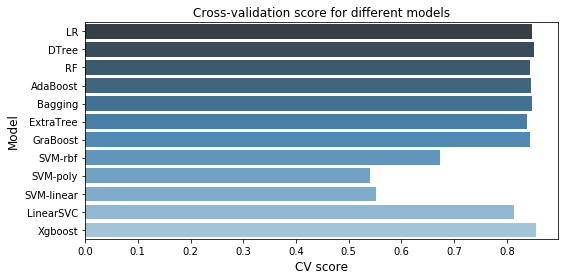

In [15]:
model_cvscore = np.hstack(( cv_score_lr, cv_score_tree, cv_score_svm, cv_score_xgb))
model_name = np.array(['LR'] + tree_name + svm_name + ['Xgboost'])
fig = plt.figure(figsize=(8,4))

sns.barplot(model_cvscore, model_name, palette="Blues_d")

plt.xticks(rotation=0, size = 10)
plt.xlabel("CV score", fontsize = 12)
plt.ylabel("Model", fontsize = 12)
plt.title("Cross-validation score for different models")

plt.tight_layout()
plt.savefig('model.png')

In [16]:
model_cv_dic = dict(zip(model_name, model_cvscore))
print(model_cv_dic)
model_cv_list = list(model_cv_dic.items())
data1 = pd.DataFrame(model_cv_list).to_csv('CVscore.csv')

{'LR': 0.8470063102404802, 'DTree': 0.850747779084123, 'RF': 0.8441947759908871, 'AdaBoost': 0.8454531451836342, 'Bagging': 0.8467996672152633, 'ExtraTree': 0.8383469939621812, 'GraBoost': 0.8439877719496909, 'SVM-rbf': 0.6731036454631842, 'SVM-poly': 0.540661651638738, 'SVM-linear': 0.5525273457540292, 'LinearSVC': 0.8127370758800001, 'Xgboost': 0.854345526072277}
